### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.7.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load the dataset and start with some preleminary exploration steps




In [23]:
df = pd.read_csv('Training.csv')
print(df.shape)
df.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [7]:
df.describe()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000
mean,6.094102,4.695539,13.337485,2.448660,2.407010,23.237929,8.231283
std,1.941639,3.374224,11.703203,3.001798,0.994063,14.298260,11.285101
min,-0.972080,-8.450380,-37.581721,-9.028060,-1.275860,-6.006860,-42.769221
25%,4.791440,2.223420,10.672820,0.468800,2.112200,12.560240,6.604160
50%,5.702780,4.668600,15.676059,2.533840,2.618500,20.151420,10.968300
75%,7.067300,7.115440,20.568080,4.656980,3.021880,31.245199,15.334100
max,15.106680,18.122899,41.138801,14.035980,6.056360,77.371620,31.024420


In [8]:
# check for null values
df.isnull().sum()

Sponginess            0
Wonder level          0
Crunchiness           0
Loudness on impact    0
Meme creativity       0
Soap slipperiness     0
Hype root             0
dtype: int64

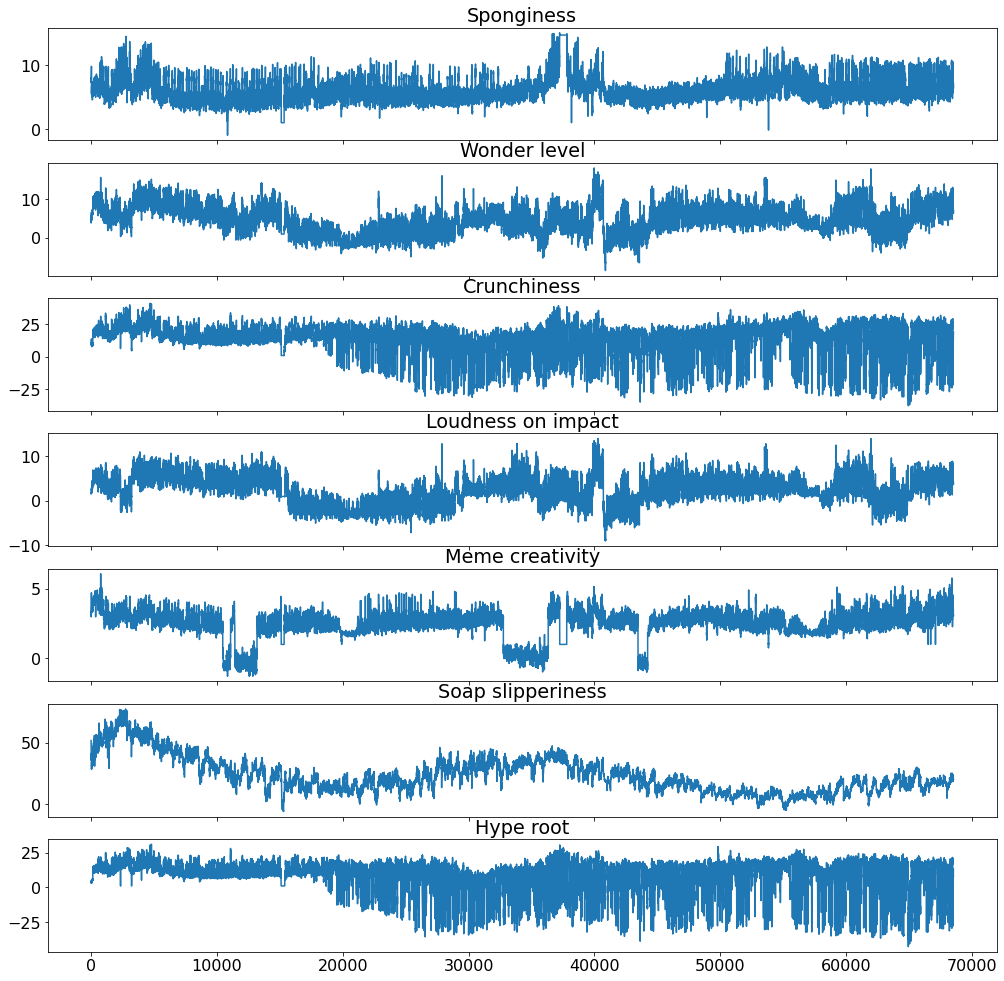

In [9]:
# visualize the data
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(df, df.columns)

### Correlation Analysis

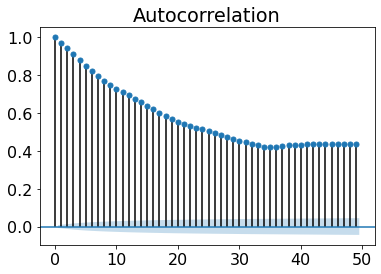

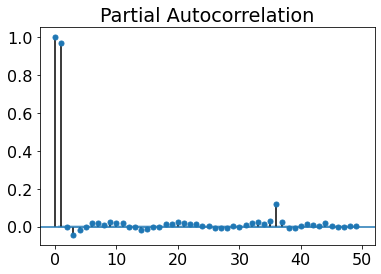

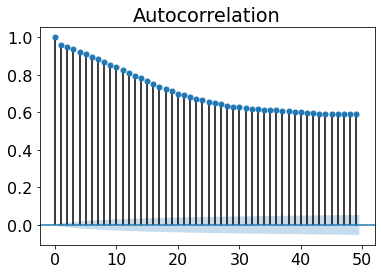

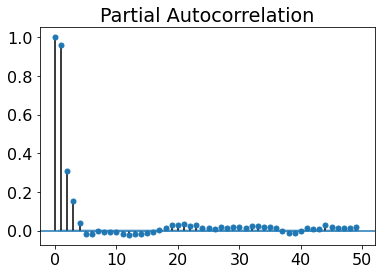

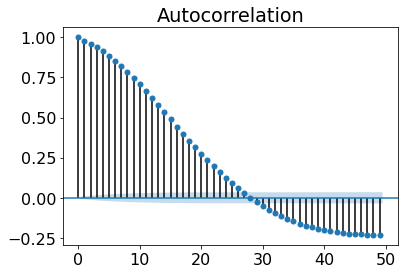

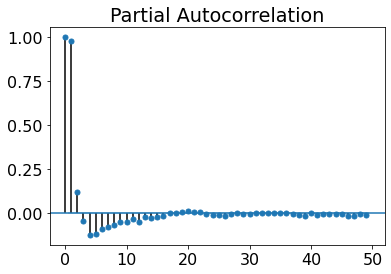

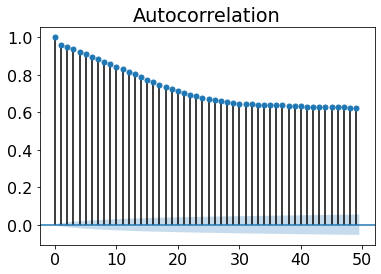

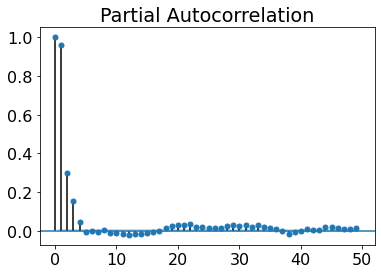

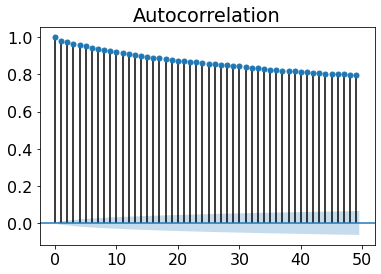

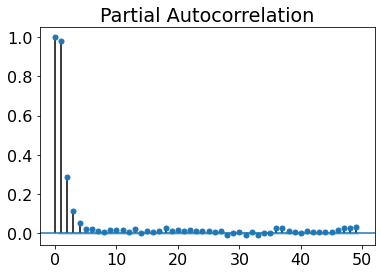

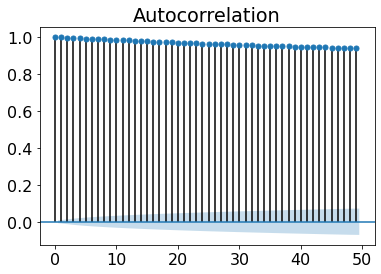

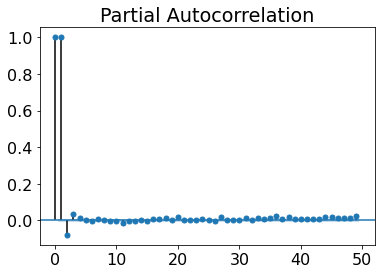

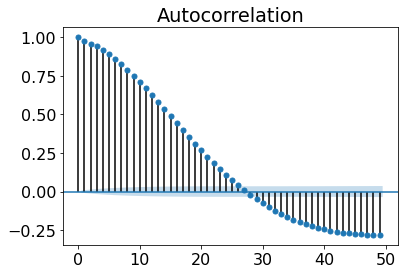

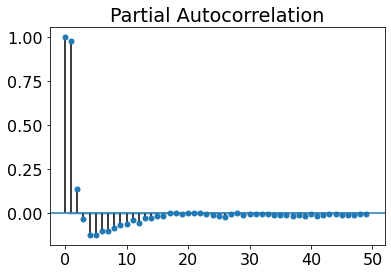

In [10]:
def inspect_corr(df, columns):
    for i, col in enumerate(columns):
        # we plot the auto correlation function and partial correlation
        acf = plot_acf(df[col])
        pacf = plot_pacf(df[col])
     
inspect_corr(df, df.columns)

We try inspected another feature that might reveal crucial to the prediction: frequency.
Through the usage of Fast Fourier Transform we wanted to get an indication of the frequencies of all of our variables, as reported below. Unfortunately the results given weren't particulary interesting for our problem, so we discarded this approach.

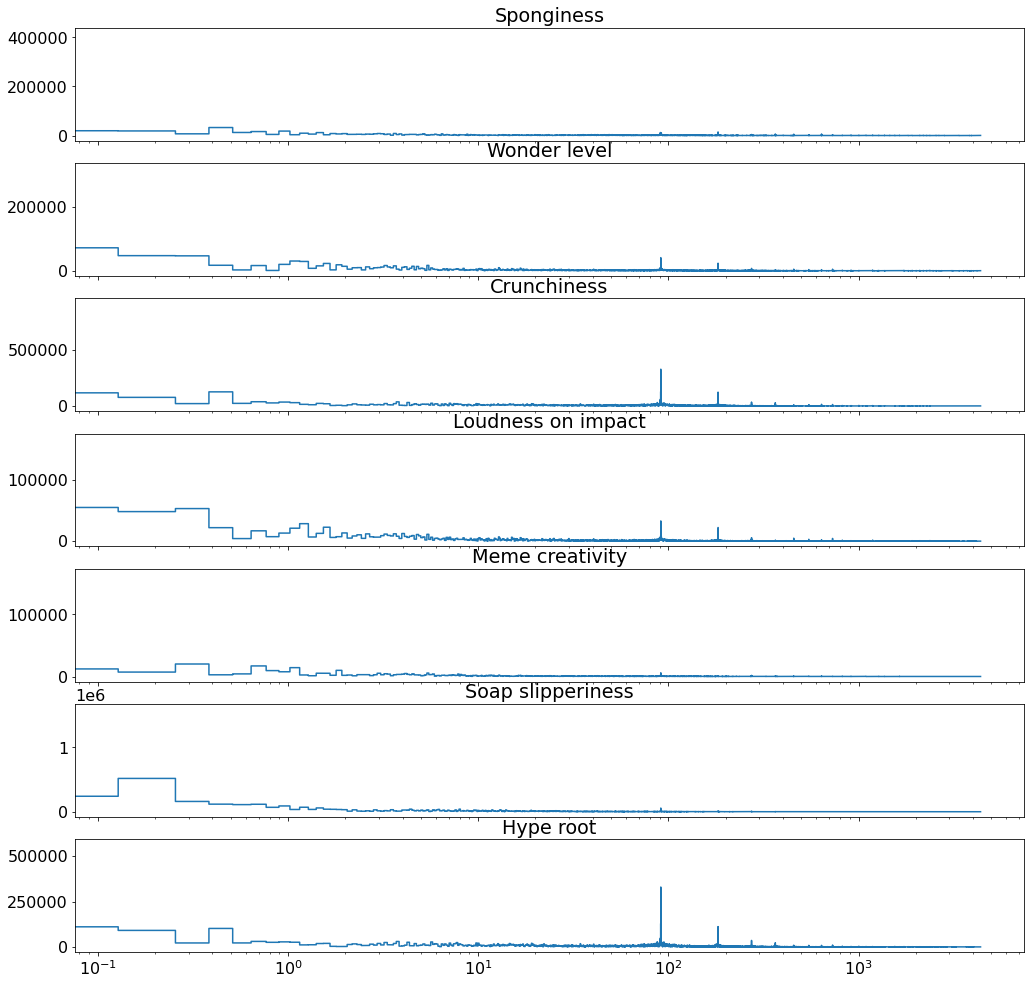

{'Sponginess': 0.3837580667756246, 'Wonder level': 0.0, 'Crunchiness': 91.20650053700678, 'Loudness on impact': 0.0, 'Meme creativity': 0.2558387111837497, 'Soap slipperiness': 0.12791935559187484, 'Hype root': 91.20650053700678}


In [65]:
def inspect_freq(df, columns):
    freqs= {}
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        fft = tf.signal.rfft(df[col])
        freq = np.argmax(np.abs(fft)[1:])
        
        f_per_df = np.arange(0, len(fft))

        n_samples_h = len(df[col])
        hours_per_year = 24*365.2524
        years_per_df = n_samples_h/(hours_per_year)

        f_per_year = f_per_df/years_per_df
        freqs[col]=f_per_year[freq]
        axs[i].step(  f_per_year, np.abs(fft))
        axs[i].set_xscale('log')
        axs[i].set_title(col)
    plt.show()
    print(freqs)
inspect_freq(df, df.columns)

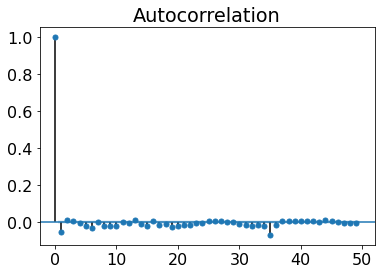

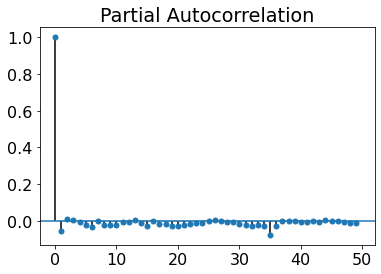

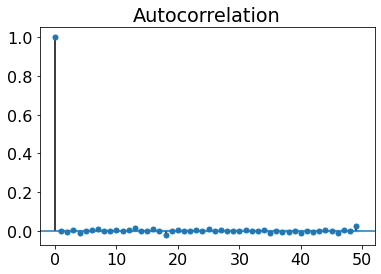

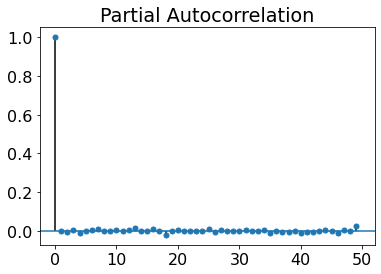

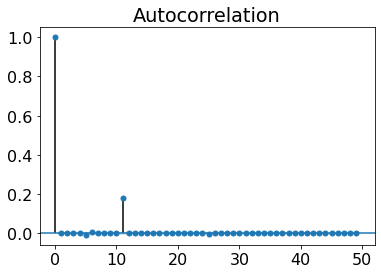

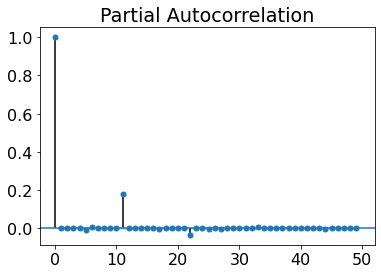

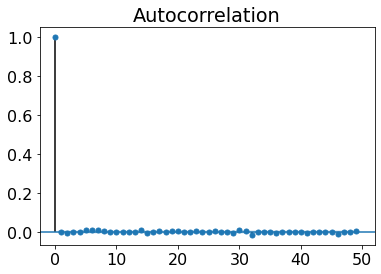

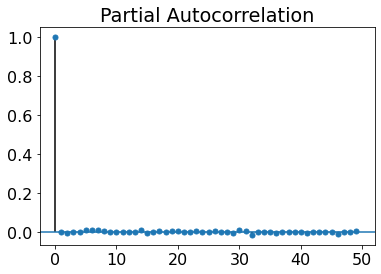

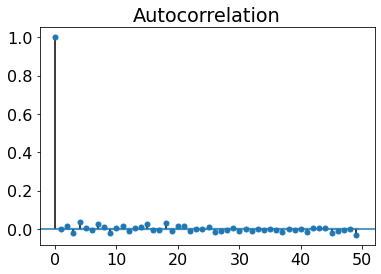

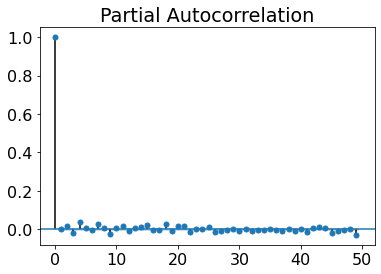

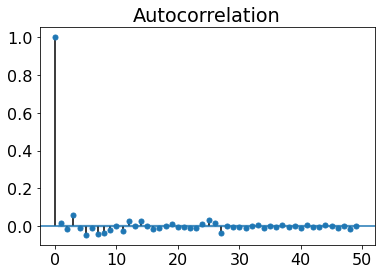

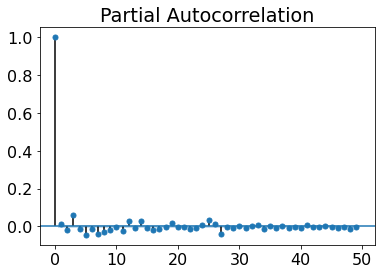

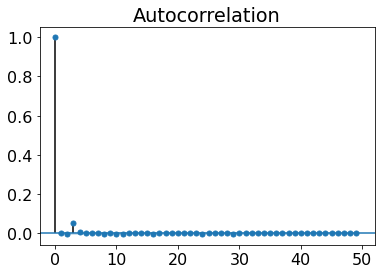

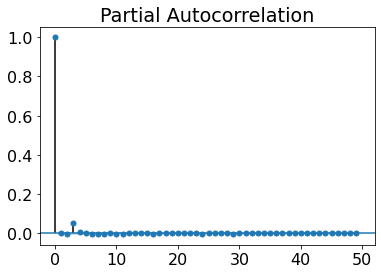

In [12]:
def inspect_pct_corr(df, columns):
    df_change = df.copy()

    for i, col in enumerate(columns):
        # let's substitute the original consumption with the percentual change
        df_change[col] = df[col].pct_change()
        df_change.dropna(inplace=True)
        # and then we plot the auto correlation function and partial correlation
        acf = plot_acf(df_change[col])
        pacf = plot_pacf(df_change[col])
     
inspect_pct_corr(df, df.columns)

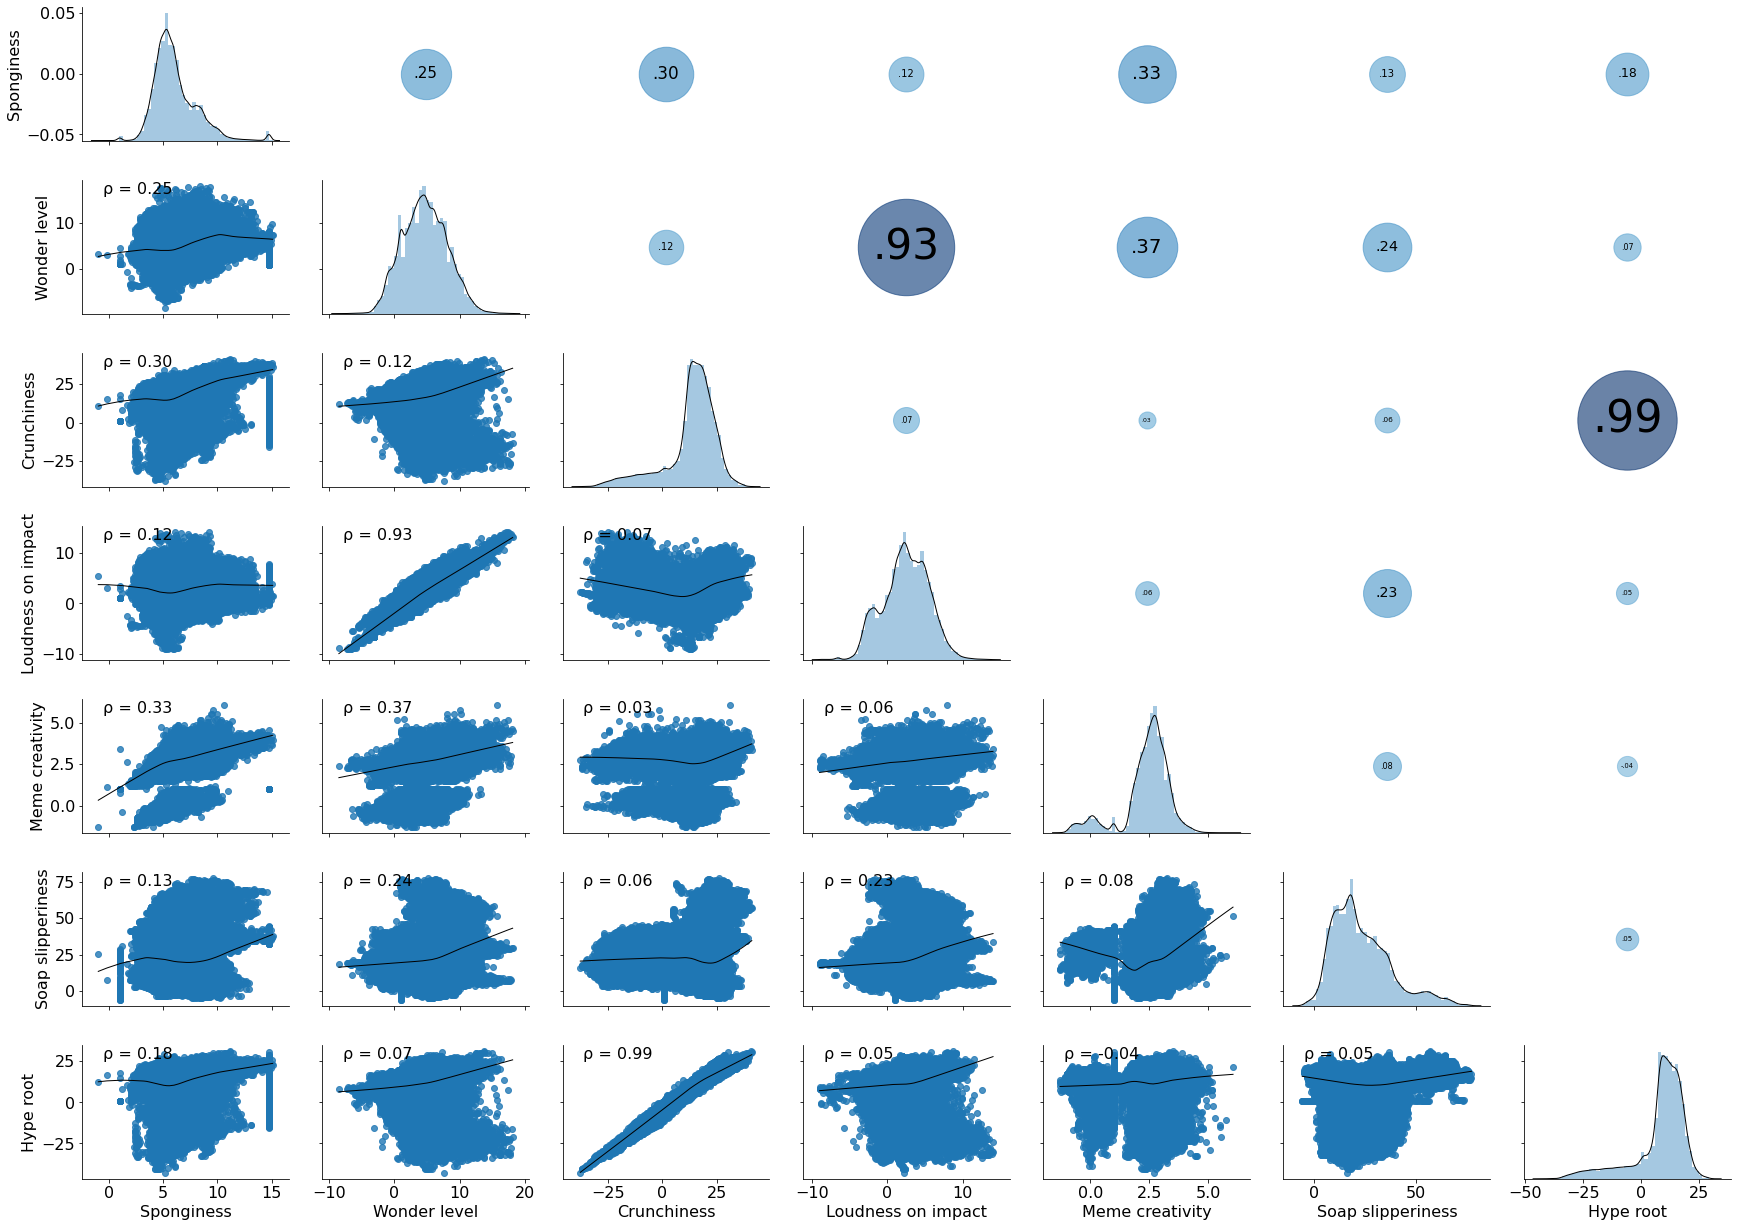

In [13]:
#let's visualize the correlation between variables in the same time steps

from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    
    
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

Let's check if our series are stationary. The most commonly used test to see this  is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the p-value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [14]:
for col in df.columns:
  print("p-value of {} : {}".format(col, adfuller(df[col])[1]))

p-value of Sponginess : 4.4272278185872816e-29
p-value of Wonder level : 8.583264566792984e-22
p-value of Crunchiness : 0.0
p-value of Loudness on impact : 1.0156147218101613e-20
p-value of Meme creativity : 5.713968086550915e-10
p-value of Soap slipperiness : 0.000778163647672343
p-value of Hype root : 0.0


Let's try to use Granger causality test to determine if one time series will be useful to forecast another. This will gives us hints to understand if is better to decompose our problem in smaller problems.

In [15]:
#esempio
df['Crunchiness'].values.shape
result_test = grangercausalitytests(df[['Crunchiness', 'Wonder level']], maxlag=20)
for k1 in result_test:
  #print(result_test[k1][0])
  for k2 in result_test[k1][0]:
    print(result_test[k1][0][k2][1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=87.9945 , p=0.0000  , df_denom=68524, df_num=1
ssr based chi2 test:   chi2=87.9983 , p=0.0000  , df=1
likelihood ratio test: chi2=87.9419 , p=0.0000  , df=1
parameter F test:         F=87.9945 , p=0.0000  , df_denom=68524, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=67.1337 , p=0.0000  , df_denom=68521, df_num=2
ssr based chi2 test:   chi2=134.2771, p=0.0000  , df=2
likelihood ratio test: chi2=134.1457, p=0.0000  , df=2
parameter F test:         F=67.1337 , p=0.0000  , df_denom=68521, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=44.2996 , p=0.0000  , df_denom=68518, df_num=3
ssr based chi2 test:   chi2=132.9125, p=0.0000  , df=3
likelihood ratio test: chi2=132.7838, p=0.0000  , df=3
parameter F test:         F=44.2996 , p=0.0000  , df_denom=68518, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=27.0593 

In [16]:
for col1 in df.columns:
  for col2 in df.columns:
    if col1!=col2:
     print('Granger test to see if {} is useful for forecasting {}.'.format(col2, col1))
     # we have to set for how many lags we want to check, let's check for the first 20 
     result_test = grangercausalitytests(df[[col1, col2]], maxlag=20,verbose=False)
     for k1 in result_test:
      for k2 in result_test[k1][0]:
        if result_test[k1][0][k2][1] > 0.01:
          print('for lag {}: {}'.format(k1,result_test[k1][0]))

Granger test to see if Wonder level is useful for forecasting Sponginess.
Granger test to see if Crunchiness is useful for forecasting Sponginess.
Granger test to see if Loudness on impact is useful for forecasting Sponginess.
Granger test to see if Meme creativity is useful for forecasting Sponginess.
Granger test to see if Soap slipperiness is useful for forecasting Sponginess.
Granger test to see if Hype root is useful for forecasting Sponginess.
Granger test to see if Sponginess is useful for forecasting Wonder level.
Granger test to see if Crunchiness is useful for forecasting Wonder level.
Granger test to see if Loudness on impact is useful for forecasting Wonder level.
Granger test to see if Meme creativity is useful for forecasting Wonder level.
Granger test to see if Soap slipperiness is useful for forecasting Wonder level.
for lag 3: {'ssr_ftest': (2.9302431122142103, 0.03221390909728975, 68518.0, 3), 'ssr_chi2test': (8.791627423354976, 0.03219351754886233, 3), 'lrtest': (8.7